In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt','r').read().splitlines()

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}  # string to index
stoi['.'] = 0  # end of word token
itos = {i:s for s,i in stoi.items()}  # index to string
vocab_size = len(stoi)
print(itos, vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 27


In [7]:
block_size = 3  # context length

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), generator=g)  # embedding matrix
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1  # input to hidden layer
b1 = torch.randn(n_hidden, generator=g) * 0.1  # hidden layer bias
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1  # hidden to output layer
b2 = torch.randn(vocab_size, generator=g) * 0.1  # output layer bias

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True  # enable gradients


11897


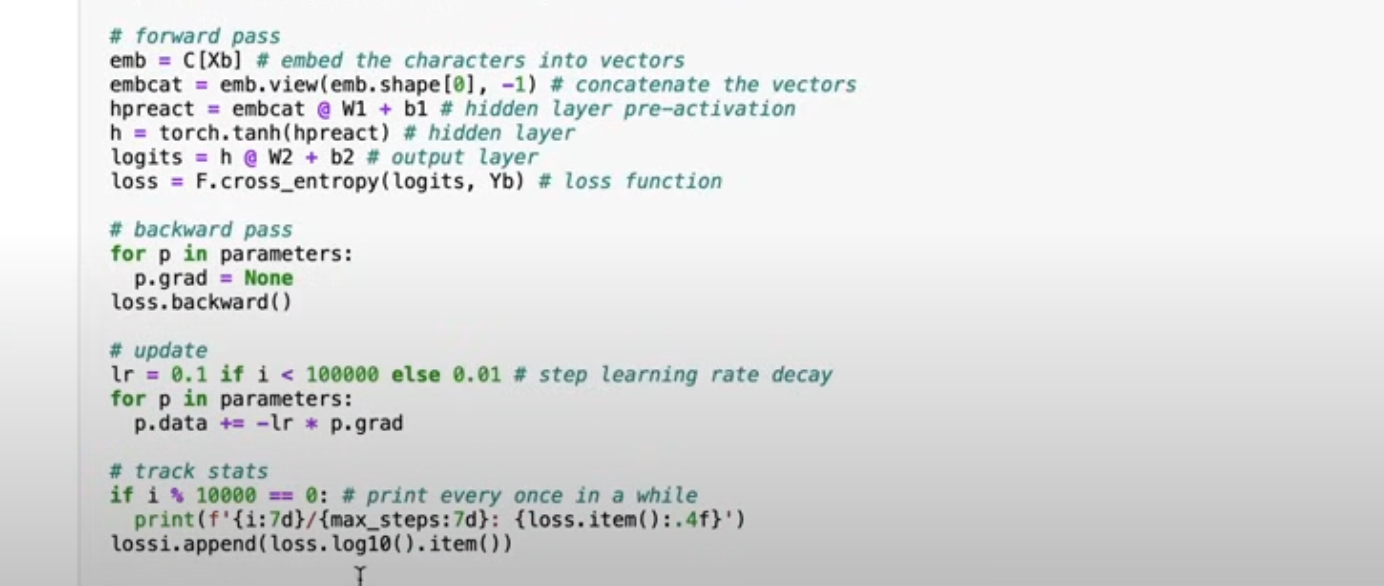

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (batch_size, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # (batch_size, n_embd * block_size)
    